# Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


# Libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [5]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [6]:
print(X_train[1][0])

[ 2.4209  -0.56039 23.654   -3.8171   1.3721   8.251  ]


In [7]:
df = pd.DataFrame()

for t in range(0, 2429):
  temp_df = pd.DataFrame(X_train[t, :, :])
  temp_df["serie"] = t
  temp_df["target"] = y_train[t]
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"x0", 1:"x1", 2:"x2", 3:"x3", 4:"x4", 5:"x5"})
print(df)

          x0        x1        x2        x3        x4       x5  serie  target
0   17.59700   8.17130  -1.78420 -19.70600  -9.71350 -61.8870      0       0
1    0.22974  -5.89560  16.83700   5.03900   2.43320  58.9140      0       0
2  -29.65400 -21.29600  29.10300  -0.47503  75.39100  10.6650      0       0
3  -59.21000 -29.56500  17.97100 -45.60600  19.41200 -43.0140      0       0
4  -72.06400 -25.85500   0.46536 -59.15100 -29.10500 -11.9130      0       0
..       ...       ...       ...       ...       ...      ...    ...     ...
31   3.51190  -1.03240  -1.69900   4.15790   2.75430   5.9823   2428      11
32   0.70853  -0.94622  -1.91760   2.09480  -4.76750   7.4118   2428      11
33   0.20638   1.02870  -0.92512  -0.71633   1.73330   4.7638   2428      11
34   4.14290   1.09390  -0.18921   1.14100   0.93441   4.1742   2428      11
35  -1.55450  -1.21210   1.07050   1.32720   2.40100   8.4550   2428      11

[87444 rows x 8 columns]


In [8]:
df.head(10000)

,x0,x1,x2,x3,x4,x5,serie,target
0,17.59700,8.1713,-1.78420,-19.70600,-9.7135,-61.8870,0,0
1,0.22974,-5.8956,16.83700,5.03900,2.4332,58.9140,0,0
2,-29.65400,-21.2960,29.10300,-0.47503,75.3910,10.6650,0,0
3,-59.21000,-29.5650,17.97100,-45.60600,19.4120,-43.0140,0,0
4,-72.06400,-25.8550,0.46536,-59.15100,-29.1050,-11.9130,0,0
...,...,...,...,...,...,...,...,...
23,37.94800,414.5400,-494.94000,317.44000,87.1800,-5.0604,277,2
24,5.69140,341.4700,374.17000,486.88000,170.6200,-60.1690,277,2
25,-46.45800,154.7100,73.85000,378.79000,14.9120,-178.3300,277,2
26,-106.42000,-38.8040,356.35000,156.19000,6.9242,-238.1600,277,2


In [9]:
window = 36
stride = 36

In [10]:
def build_sequences(df, window=36, stride=36):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for s in df['serie'].unique():
        # Take only meaningful features
        temp = df[df['serie'] == s][['x0', 'x1', 'x2', 'x3', 'x4', 'x5']].values
        # Save the label
        label = df[df['serie'] == s]['target'].values[0]
        # Compute padding length
        #padding_len = window - len(temp)%window
        # Create padding and concatenate it
        #padding = np.zeros((padding_len,6), dtype='float64')
        #temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [11]:
X_train, y_train = build_sequences(df, window, stride)
#X_test, y_test = build_sequences(df_test, window, stride)
X_train.shape, y_train.shape, 
#X_test.shape, y_test.shape

((2429, 36, 6), (2429,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train ,random_state=104, test_size=0.15, shuffle=True)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064,), (365, 36, 6), (365,))

In [14]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064, 12), (365, 36, 6), (365, 12))

In [15]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [16]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [17]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 218,764
Trainable params: 218,764
Non-trainable

In [18]:
# Train the model
history = model.fit(
    x = X_train[:,:,:],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 9s 338ms/step - loss: 2.1940 - accuracy: 0.2940 - val_loss: 1.9597 - val_accuracy: 0.3623 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 7s 475ms/step - loss: 1.7487 - accuracy: 0.4421 - val_loss: 1.6850 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 6s 394ms/step - loss: 1.4890 - accuracy: 0.4847 - val_loss: 1.4458 - val_accuracy: 0.4638 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 5s 311ms/step - loss: 1.3211 - accuracy: 0.5428 - val_loss: 1.3362 - val_accuracy: 0.5314 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 6s 367ms/step - loss: 1.1752 - accuracy: 0.5875 - val_loss: 1.2919 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 3s 218ms/step - loss: 1.0878 - accuracy: 0.6241 - val_loss: 1.2346 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 3s 216ms/st

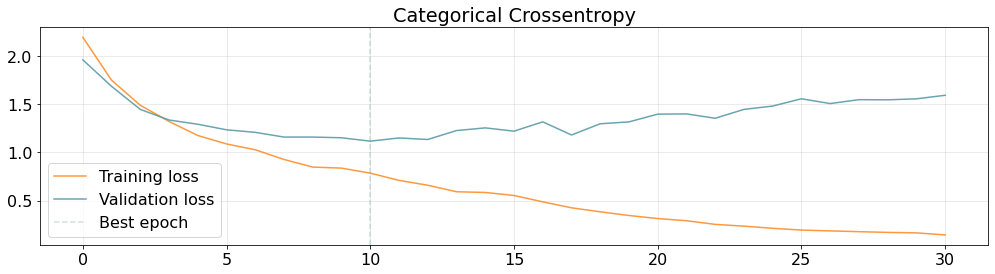

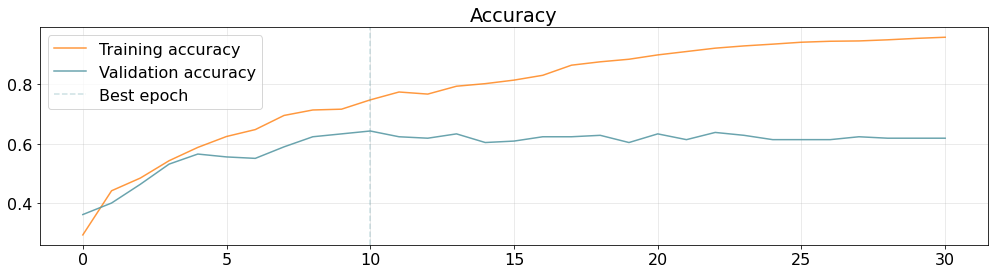

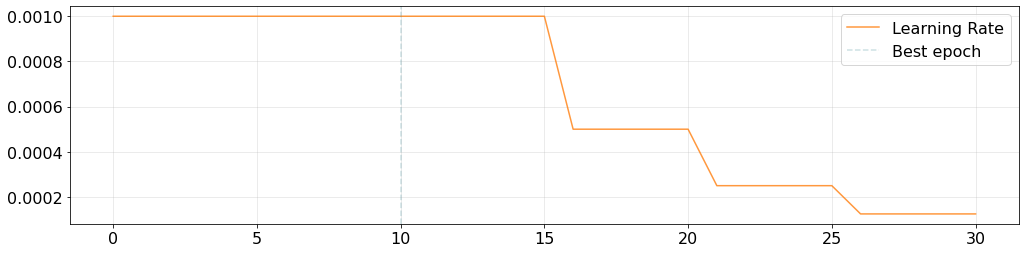

In [19]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [20]:
model.save('new_df/LSTM')
# model = tfk.models.load_model('LSTM')

In [21]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
predictions.shape

12/12 [==============================] - 1s 35ms/step


(365, 12)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6493
Precision: 0.4771
Recall: 0.4676
F1: 0.457


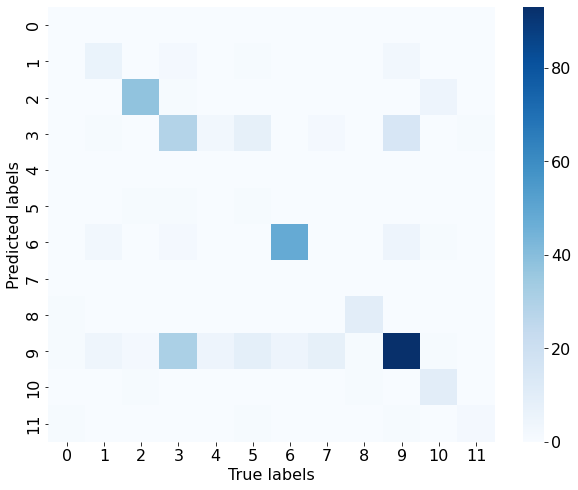

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [23]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [24]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 12)                1548  

In [25]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 15s 599ms/step - loss: 1.9533 - accuracy: 0.3796 - val_loss: 1.7131 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 7s 464ms/step - loss: 1.4794 - accuracy: 0.4943 - val_loss: 1.4078 - val_accuracy: 0.5121 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 10s 665ms/step - loss: 1.2303 - accuracy: 0.5784 - val_loss: 1.2396 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 7s 458ms/step - loss: 1.0535 - accuracy: 0.6462 - val_loss: 1.1537 - val_accuracy: 0.6039 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 7s 462ms/step - loss: 0.9301 - accuracy: 0.6957 - val_loss: 1.2004 - val_accuracy: 0.5797 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 7s 460ms/step - loss: 0.8293 - accuracy: 0.7243 - val_loss: 1.1571 - val_accuracy: 0.6232 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 7s 457ms/

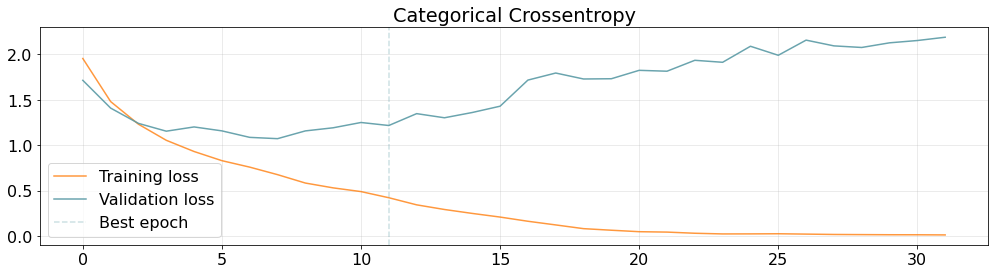

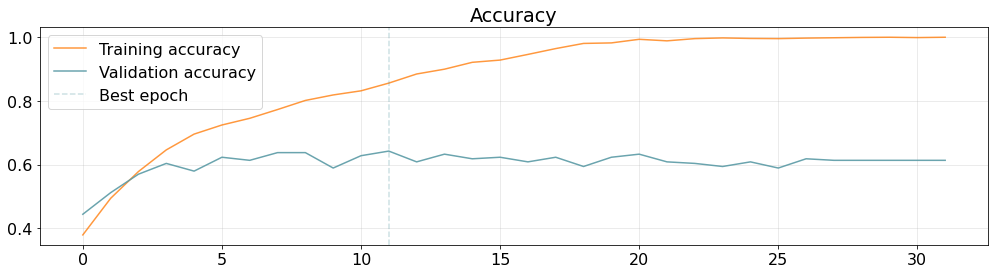

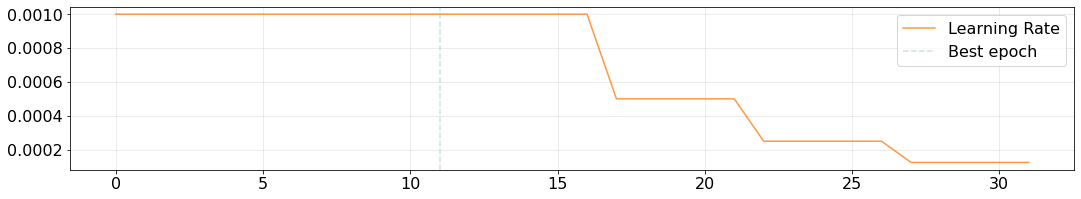

In [26]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [27]:
model.save('new_df/BiLSTM/start_new_df')
# model = tfk.models.load_model('BiLSTM')

In [28]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

12/12 [==============================] - 2s 72ms/step


(365, 12)

Accuracy: 0.6438
Precision: 0.5534
Recall: 0.5359
F1: 0.501


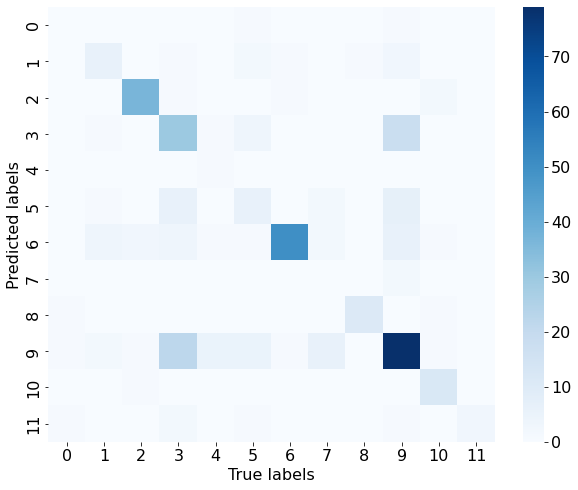

In [29]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [30]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [31]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [32]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 1s 45ms/step - loss: 18.7680 - accuracy: 0.0991 - val_loss: 5.5993 - val_accuracy: 0.0773 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 0s 29ms/step - loss: 9.5533 - accuracy: 0.1093 - val_loss: 8.3309 - val_accuracy: 0.0338 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 0s 31ms/step - loss: 5.8020 - accuracy: 0.1815 - val_loss: 4.3344 - val_accuracy: 0.2174 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 0s 30ms/step - loss: 3.7308 - accuracy: 0.2472 - val_loss: 3.3025 - val_accuracy: 0.2705 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 0s 30ms/step - loss: 2.9160 - accuracy: 0.3156 - val_loss: 2.7265 - val_accuracy: 0.3478 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 0s 30ms/step - loss: 2.5892 - accuracy: 0.3619 - val_loss: 2.4650 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 0s 29ms/step - l

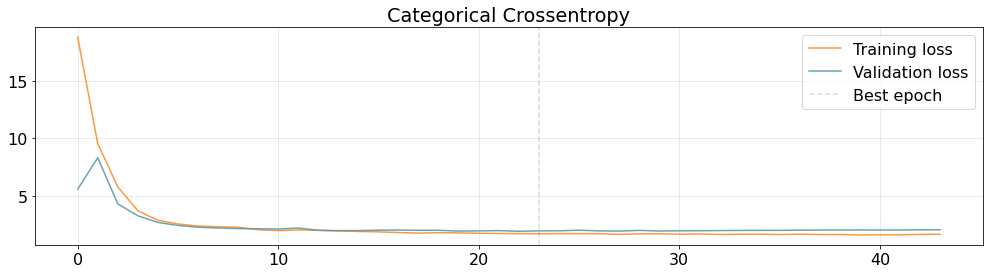

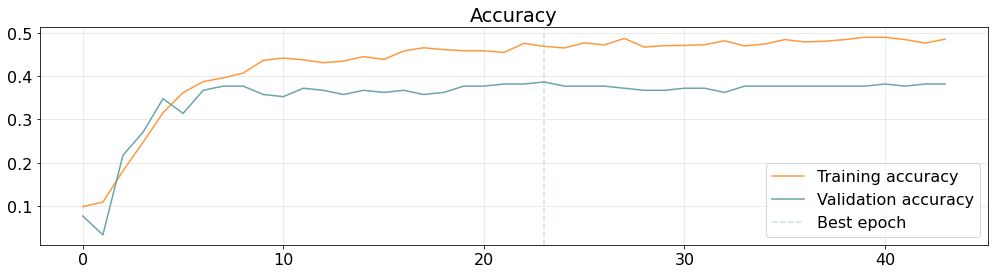

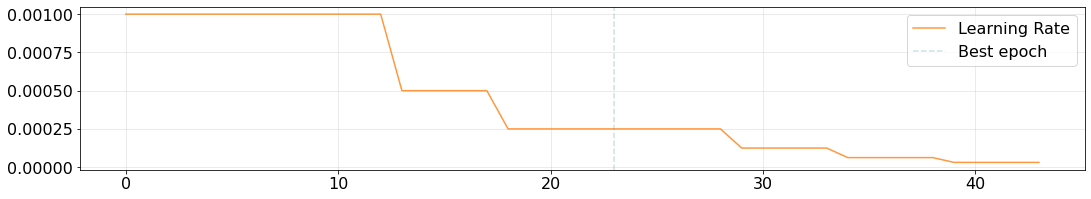

In [33]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [34]:
model.save('new_df/1DCNN/start')
# model = tfk.models.load_model('1DCNN')

In [35]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

12/12 [==============================] - 0s 4ms/step


(365, 12)

Accuracy: 0.4603
Precision: 0.3866
Recall: 0.2815
F1: 0.285


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


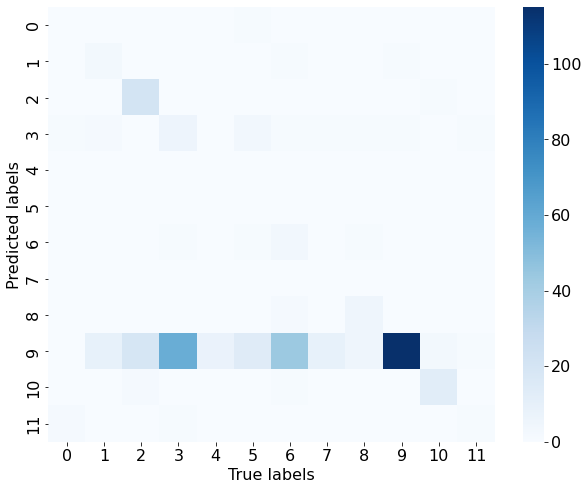

In [36]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()